In [1]:
import pandas as pd
import numpy as np
import re, nltk, spacy, os, pickle
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
## Read data
df = pd.read_pickle('../Data/icd_clean.pkl')

## Parameters
sample = 1_000_000
batch_size = 16
num_epochs = 10
random_state = 2011
test_size = 0.2
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

df = df.sample(sample, random_state = random_state)[['cause','causa_icd']]
label_mapping = {value:label for label, value in enumerate(df['causa_icd'].unique())}
df['label'] = df['causa_icd'].map(label_mapping)
text, label = df['cause'].values, df['label'].values
vocabulary = set([word for item in text for word in str(item).split()])
vocab_size = len(vocabulary)


## 2. Vocabulary and tokenization

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence

tokenizer = Tokenizer(num_words = vocab_size, 
                      oov_token = '<OOV>')
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
tensor_sequences = [torch.tensor(seq) for seq in sequences]
padded_sequences = pad_sequence(tensor_sequences, 
                                batch_first = True,
                                padding_value = 0)
# label to tensor
tensor_label = torch.tensor(label, dtype=torch.long)

## 3. Split train data

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  padded_sequences, tensor_label, 
  test_size = test_size, random_state = random_state
)
from torch.utils.data import DataLoader, TensorDataset, Dataset
train_dataloader = DataLoader(TensorDataset(X_train, y_train),
                              batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(TensorDataset(X_test, y_test),
                             batch_size=batch_size, shuffle=False)

In [5]:
## 1. BIGRU
class BiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, embedding_matrix=None):
        super(BiGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(embedding_matrix, requires_grad=False)

        self.bigru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # hidden_dim * 2 to account for bidirectional output

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bigru(x)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x
    
## 2. Bigru with attention
class BiGRUWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, embedding_matrix=None):
        super(BiGRUWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(embedding_matrix, requires_grad=False)

        self.bigru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)  # Attention layer
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Fully connected layer

    def forward(self, x):
        x = self.embedding(x)
        gru_output, _ = self.bigru(x)  # Output from the BiGRU (batch_size, seq_length, hidden_dim * 2)

        # Compute attention scores
        attention_scores = torch.tanh(self.attention(gru_output))  # (batch_size, seq_length, 1)
        attention_weights = F.softmax(attention_scores, dim=1)  # Normalize scores (batch_size, seq_length, 1)

        # Create context vector
        context_vector = torch.sum(attention_weights * gru_output, dim=1)  # Weighted sum of outputs (batch_size, hidden_dim * 2)

        # Final fully connected layer
        output = self.fc(context_vector)
        return output
    
## 3. Seq2Seq model
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout = 0.5):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        x = self.dropout(x)
        outputs, hidden = self.bigru(x, h0)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size * 3, hidden_size)  # Corrected to hidden_size * 3
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs, hidden):
        batch_size, seq_len, _ = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # Repeat hidden state
        # Concatenate hidden state and encoder outputs
        combined = torch.cat((encoder_outputs, hidden), dim=2)
        energy = torch.tanh(self.attention(combined))
        attention_weights = torch.softmax(self.v(energy), dim=1)
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)
        return context_vector, attention_weights

class DecoderWithAttention(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1, dropout=0.5):
        super(DecoderWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(hidden_size + output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, encoder_outputs):
        context_vector, attention_weights = self.attention(encoder_outputs, hidden[-1])
        # Ensure x and context_vector have compatible dimensions for concatenation
        x = torch.cat((x, context_vector.unsqueeze(1)), dim=2)
        x = self.dropout(x)
        output, hidden = self.gru(x, hidden)
        output = self.fc(output.squeeze(1))
        return output, hidden, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, input_size, embedding_size, output_size, hidden_size, num_layers=1, dropout=0.5):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.encoder = Encoder(embedding_size, hidden_size, num_layers, dropout)
        self.decoder = DecoderWithAttention(output_size, hidden_size, num_layers, dropout)

    def forward(self, src, trg):
        embedded = self.embedding(src)
        encoder_outputs, hidden = self.encoder(embedded)
        
        hidden = hidden.view(self.encoder.num_layers, 2, -1, self.encoder.hidden_size)
        hidden = hidden.sum(dim=1)
        
        output = torch.zeros((trg.size(0), 1, self.decoder.output_size)).to(src.device)
        outputs = []

        if trg.ndim == 1:
            trg = trg.unsqueeze(1)
        
        for t in range(trg.size(1)):
            output, hidden, _ = self.decoder(output, hidden, encoder_outputs)
            outputs.append(output.unsqueeze(1))

            if t < trg.size(1) - 1:
                output = trg[:, t].unsqueeze(1).float()
        
        outputs = torch.cat(outputs, dim=1)
        return outputs

## 4. Transformer Seq2Seq
class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_size, num_layers, num_classes, max_length=100):
        super(TransformerSeq2Seq, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_size)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(embed_size, num_classes)

    def forward(self, src):
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        encoder_output = self.encoder(src.permute(1, 0, 2))
        encoder_output = encoder_output.mean(dim=0)  # Global average pooling
        output = self.decoder(encoder_output)
        return output


In [6]:
embedding_dim = 512
hidden_dim = 128
num_layers = 2
num_classes = len(torch.unique(tensor_label))
embedding_matrix = None
num_heads = 4
patience = 3

bigru = BiGRU(vocab_size,
              embedding_dim=embedding_dim,
              num_layers = num_layers,
              hidden_dim=hidden_dim,
              num_classes=num_classes,
              embedding_matrix=embedding_matrix)
bigruwithattention = BiGRUWithAttention(vocab_size,
                   embedding_dim=embedding_dim,
                   hidden_dim = hidden_dim,
                   num_layers = num_layers,
                   num_classes=num_classes,
                   embedding_matrix=embedding_matrix)
seq2seq = Seq2Seq(vocab_size,
        embedding_size=embedding_dim,
        output_size = num_classes, 
        hidden_size=hidden_dim)

transformer_seq = TransformerSeq2Seq(vocab_size,
                                     embed_size=embedding_dim,
                                     num_heads = num_heads,
                                     hidden_size = hidden_dim,
                                     num_layers = num_layers,
                                     num_classes = num_classes
                                     )
bigru, bigruwithattention, seq2seq, transformer_seq


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


(BiGRU(
   (embedding): Embedding(4955, 512)
   (bigru): GRU(512, 128, num_layers=2, batch_first=True, bidirectional=True)
   (fc): Linear(in_features=256, out_features=20, bias=True)
 ),
 BiGRUWithAttention(
   (embedding): Embedding(4955, 512)
   (bigru): GRU(512, 128, num_layers=2, batch_first=True, bidirectional=True)
   (attention): Linear(in_features=256, out_features=1, bias=True)
   (fc): Linear(in_features=256, out_features=20, bias=True)
 ),
 Seq2Seq(
   (embedding): Embedding(4955, 512)
   (encoder): Encoder(
     (dropout): Dropout(p=0.5, inplace=False)
     (bigru): GRU(512, 128, batch_first=True, bidirectional=True)
   )
   (decoder): DecoderWithAttention(
     (attention): Attention(
       (attention): Linear(in_features=384, out_features=128, bias=True)
       (v): Linear(in_features=128, out_features=1, bias=False)
     )
     (gru): GRU(148, 128, batch_first=True)
     (fc): Linear(in_features=128, out_features=20, bias=True)
     (dropout): Dropout(p=0.5, inplace=Fa

from tqdm import tqdm  # Import tqdm for progress bars

def train_and_evaluate_model(model, train_loader, test_loader, 
                             criterion, optimizer, num_epochs, 
                             patience=3, device='cuda'):
    """
    Train and evaluate a given model.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the testing set.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        num_epochs (int): Number of epochs to train.
        patience (int): Number of epochs to wait before early stopping.
        device (str): Device to use for training (e.g., 'cuda' or 'cpu').

    Returns:
        tuple: Training losses, training accuracy, evaluation accuracy, evaluation precision, evaluation recall, evaluation F1 score.
    """
    
    # Move model to the specified device
    model.to(device)
    
    # Lists to store metrics for each epoch
    training_losses = []
    training_accuracy = []
    evaluation_accuracy = []
    evaluation_precision = []
    evaluation_recall = []
    evaluation_f1 = []
    
    best_f1 = 0  # Best F1 score for early stopping
    epochs_without_improvement = 0  # Count of epochs without improvement
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total = 0
        correct = 0
        epoch_loss = 0

        # Initialize tqdm progress bar for training phase
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training", leave=False)

        for src, trg in train_progress:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            if isinstance(model, TransformerSeq2Seq):
                src_mask = torch.triu(torch.ones(src.size(1), src.size(1)) * float('-inf'), diagonal=1).to(device)
                outputs = model(src)
            elif isinstance(model, Seq2Seq):
                num_classes = len(torch.unique(trg))
                output_size = model.decoder.output_size if hasattr(model.decoder, 'output_size') else num_classes
                trg_onehot = torch.nn.functional.one_hot(trg, num_classes=output_size).float().to(device)
                outputs = model(src, trg_onehot)
            else:
                outputs = model(src)
            
            # Reshape outputs and target based on model type
            if outputs.dim() == 3:  # (batch_size, seq_len, num_classes)
                batch_size, seq_len, num_classes = outputs.size()
                
                if trg.dim() == 1 or (trg.dim() == 2 and trg.size(1) == 1):
                    trg = trg.view(-1)
                    outputs = outputs[:, 0, :]  # Take the output of the first timestep
                else:
                    if trg.size(1) != seq_len:
                        raise ValueError(f"Mismatch in sequence length: output seq_len = {seq_len}, target seq_len = {trg.size(1)}")
                    outputs = outputs.view(batch_size * seq_len, num_classes)  # Flatten to (batch_size * seq_len, num_classes)
                    trg = trg.view(batch_size * seq_len)  # Flatten target to (batch_size * seq_len)
            
            elif outputs.dim() == 2:  # (batch_size, num_classes)
                batch_size, num_classes = outputs.size()
                trg = trg.view(batch_size)  # Ensure target is flattened to (batch_size)
            
            # Compute loss
            loss = criterion(outputs, trg)
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            epoch_loss += loss.item() * trg.size(0)
            _, predicted = torch.max(outputs, 1)
            total += trg.size(0)
            correct += (predicted == trg).sum().item()

            # Update training progress bar
            train_progress.set_postfix(loss=loss.item(), train_acc=100 * correct / total)
        
        # Average loss and accuracy for the epoch
        epoch_loss /= total
        epoch_accuracy = 100 * correct / total
        training_losses.append(epoch_loss)
        training_accuracy.append(epoch_accuracy)
        
        # Evaluation phase
        model.eval()
        all_preds = []
        all_labels = []

        # Initialize tqdm progress bar for evaluation phase
        eval_progress = tqdm(test_loader, desc=f"Epoch {epoch+1} - Evaluation", leave=False)

        with torch.no_grad():
            for src, trg in eval_progress:
                src, trg = src.to(device), trg.to(device)
                if isinstance(model, TransformerSeq2Seq):
                    src_mask = torch.triu(torch.ones(src.size(1), src.size(1)) * float('-inf'), diagonal=1).to(device)
                    outputs = model(src)
                elif isinstance(model, Seq2Seq):
                    output_size = model.decoder.output_size if hasattr(model.decoder, 'output_size') else num_classes
                    trg_onehot = torch.nn.functional.one_hot(trg, num_classes=output_size).float().to(device)
                    outputs = model(src, trg_onehot)
                else:
                    outputs = model(src)

                if outputs.dim() == 3:  # (batch_size, seq_len, num_classes)
                    batch_size, seq_len, num_classes = outputs.size()
                    
                    if trg.dim() == 1 or (trg.dim() == 2 and trg.size(1) == 1):
                        trg = trg.view(-1)
                        outputs = outputs[:, 0, :]
                    else:
                        if trg.size(1) != seq_len:
                            raise ValueError(f"Mismatch in sequence length during evaluation: output seq_len = {seq_len}, target seq_len = {trg.size(1)}")
                        outputs = outputs.view(batch_size * seq_len, num_classes)
                        trg = trg.view(batch_size * seq_len)
                
                _, predicted = torch.max(outputs, dim=-1)
                
                all_preds.extend(predicted.cpu().numpy().flatten())
                all_labels.extend(trg.cpu().numpy().flatten())

                # Update evaluation progress bar
                eval_progress.set_postfix(eval_acc=accuracy_score(all_labels, all_preds))
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        evaluation_accuracy.append(accuracy)
        evaluation_precision.append(precision)
        evaluation_recall.append(recall)
        evaluation_f1.append(f1)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%, '
              f'Evaluation Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
        
        # Early stopping check
        if f1 > best_f1:
            best_f1 = f1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break
    
    return training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1


import os
import torch
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import pickle

# Function to save the model and tokenizer
def save_model_and_tokenizer(model, tokenizer, model_name, save_dir='saved_models'):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save the model state dict
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), model_path)
    
    # Save the tokenizer
    tokenizer_path = os.path.join(save_dir, f"{model_name}_tokenizer.pkl")
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    
    print(f"Model and tokenizer saved to {model_path} and {tokenizer_path}")

# Initialize dictionaries to store results
results = {
    'transformerseq2seq': {'loss': [], 'train_acc': [], 'eval_acc': [], 'precision': [], 'recall': [], 'f1': []},
    'bigru': {'loss': [], 'train_acc': [], 'eval_acc': [], 'precision': [], 'recall': [], 'f1': []},
    'bigruwithattention': {'loss': [], 'train_acc': [], 'eval_acc': [], 'precision': [], 'recall': [], 'f1': []}
}

# Assuming 'tokenizer' is already defined in your environment
# Example tokenizer object, replace this with your actual tokenizer
tokenizer = {'word_to_idx': {}, 'idx_to_word': {}}  # Placeholder tokenizer, replace with actual tokenizer

# Training each model
for model in [transformer_seq, bigru, bigruwithattention]:
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_dataset = TensorDataset(X_train, y_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_dataset.tensors[1].cpu().numpy()),
        y=train_dataset.tensors[1].cpu().numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f"\nTraining model: {type(model).__name__}")
    
    # Add tqdm for progress bar during training
    with tqdm(total=num_epochs, desc=f"Training {type(model).__name__}", unit="epoch") as pbar:
        losses, train_acc, eval_acc, precision, recall, f1 = train_and_evaluate_model(
            model, train_dataloader, test_dataloader, criterion, optimizer, 
            num_epochs, patience, device
        )
    
    # Collect the results
    model_name = type(model).__name__.lower()
    print(model_name)
    results[model_name]['loss'] = losses
    results[model_name]['train_acc'] = train_acc
    results[model_name]['eval_acc'] = eval_acc
    results[model_name]['precision'] = precision
    results[model_name]['recall'] = recall
    results[model_name]['f1'] = f1
    
    # Save the model and tokenizer
    save_model_and_tokenizer(model, tokenizer, model_name)



Training model: TransformerSeq2Seq


Training transformerseq2seq:  10%|█         | 1/10 [10:39<1:35:57, 639.68s/epoch, eval_acc=0.945, loss=0.268, train_acc=91.7]

Epoch 1, Loss: 0.2680, Training Accuracy: 91.72%, Evaluation Accuracy: 0.9453, Precision: 0.9329, Recall: 0.9289, F1-Score: 0.9206


Training transformerseq2seq:  20%|██        | 2/10 [20:18<1:20:30, 603.77s/epoch, eval_acc=0.948, loss=0.208, train_acc=93.3]

Epoch 2, Loss: 0.2081, Training Accuracy: 93.26%, Evaluation Accuracy: 0.9484, Precision: 0.9374, Recall: 0.9323, F1-Score: 0.9260


Training transformerseq2seq:  30%|███       | 3/10 [29:54<1:08:57, 591.14s/epoch, eval_acc=0.952, loss=0.198, train_acc=93.8]

Epoch 3, Loss: 0.1976, Training Accuracy: 93.84%, Evaluation Accuracy: 0.9520, Precision: 0.9426, Recall: 0.9354, F1-Score: 0.9302


Training transformerseq2seq:  40%|████      | 4/10 [39:32<58:34, 585.83s/epoch, eval_acc=0.913, loss=0.187, train_acc=94.1]  

Epoch 4, Loss: 0.1865, Training Accuracy: 94.09%, Evaluation Accuracy: 0.9128, Precision: 0.9141, Recall: 0.9327, F1-Score: 0.9055


Training transformerseq2seq:  50%|█████     | 5/10 [49:09<48:34, 582.95s/epoch, eval_acc=0.952, loss=0.184, train_acc=94.1]

Epoch 5, Loss: 0.1841, Training Accuracy: 94.11%, Evaluation Accuracy: 0.9517, Precision: 0.9405, Recall: 0.9357, F1-Score: 0.9300


Training transformerseq2seq:  60%|██████    | 6/10 [58:48<38:45, 581.47s/epoch, eval_acc=0.952, loss=0.177, train_acc=94.3]

Epoch 6, Loss: 0.1773, Training Accuracy: 94.33%, Evaluation Accuracy: 0.9522, Precision: 0.9432, Recall: 0.9357, F1-Score: 0.9304


Training transformerseq2seq:  70%|███████   | 7/10 [1:08:27<29:01, 580.64s/epoch, eval_acc=0.951, loss=0.175, train_acc=94.4]

Epoch 7, Loss: 0.1746, Training Accuracy: 94.37%, Evaluation Accuracy: 0.9514, Precision: 0.9355, Recall: 0.9355, F1-Score: 0.9297


Training transformerseq2seq:  80%|████████  | 8/10 [1:18:06<19:20, 580.14s/epoch, eval_acc=0.942, loss=0.175, train_acc=94.3]

Epoch 8, Loss: 0.1753, Training Accuracy: 94.28%, Evaluation Accuracy: 0.9415, Precision: 0.9190, Recall: 0.9369, F1-Score: 0.9247


Training transformerseq2seq:  90%|█████████ | 9/10 [1:27:46<09:40, 580.01s/epoch, eval_acc=0.953, loss=0.173, train_acc=94.4]

Epoch 9, Loss: 0.1730, Training Accuracy: 94.39%, Evaluation Accuracy: 0.9530, Precision: 0.9440, Recall: 0.9370, F1-Score: 0.9318


Training transformerseq2seq: 100%|██████████| 10/10 [1:37:25<00:00, 584.55s/epoch, eval_acc=0.952, loss=0.17, train_acc=94.5] 


Epoch 10, Loss: 0.1695, Training Accuracy: 94.49%, Evaluation Accuracy: 0.9522, Precision: 0.9384, Recall: 0.9366, F1-Score: 0.9313
Model and tokenizer saved to saved_models/transformerseq2seq.pth and saved_models/transformerseq2seq_tokenizer.pkl

Training model: BiGRU


Training bigru:  10%|█         | 1/10 [50:09<7:31:21, 3009.11s/epoch, eval_acc=0.954, loss=0.174, train_acc=93.8]

Epoch 1, Loss: 0.1739, Training Accuracy: 93.83%, Evaluation Accuracy: 0.9537, Precision: 0.9454, Recall: 0.9378, F1-Score: 0.9327


Training bigru:  20%|██        | 2/10 [1:40:09<6:40:29, 3003.70s/epoch, eval_acc=0.924, loss=0.16, train_acc=94.2] 

Epoch 2, Loss: 0.1603, Training Accuracy: 94.16%, Evaluation Accuracy: 0.9244, Precision: 0.9142, Recall: 0.9362, F1-Score: 0.9143


Training bigru:  30%|███       | 3/10 [2:29:46<5:49:01, 2991.68s/epoch, eval_acc=0.951, loss=0.159, train_acc=94.2]

Epoch 3, Loss: 0.1586, Training Accuracy: 94.24%, Evaluation Accuracy: 0.9510, Precision: 0.9335, Recall: 0.9367, F1-Score: 0.9294


Training bigru:  30%|███       | 3/10 [3:19:56<7:46:30, 3998.67s/epoch, eval_acc=0.951, loss=0.159, train_acc=94.2]


Epoch 4, Loss: 0.1575, Training Accuracy: 94.30%, Evaluation Accuracy: 0.9422, Precision: 0.9195, Recall: 0.9382, F1-Score: 0.9255
Early stopping triggered.
Model and tokenizer saved to saved_models/bigru.pth and saved_models/bigru_tokenizer.pkl

Training model: BiGRUWithAttention


Training bigruwithattention:  10%|█         | 1/10 [51:05<7:39:49, 3065.54s/epoch, eval_acc=0.943, loss=0.172, train_acc=93.9]

Epoch 1, Loss: 0.1716, Training Accuracy: 93.88%, Evaluation Accuracy: 0.9434, Precision: 0.9201, Recall: 0.9382, F1-Score: 0.9262


Training bigruwithattention:  20%|██        | 2/10 [1:42:20<6:49:30, 3071.35s/epoch, eval_acc=0.943, loss=0.159, train_acc=94.2]

Epoch 2, Loss: 0.1586, Training Accuracy: 94.22%, Evaluation Accuracy: 0.9432, Precision: 0.9195, Recall: 0.9381, F1-Score: 0.9259


Training bigruwithattention:  30%|███       | 3/10 [2:33:36<5:58:33, 3073.30s/epoch, eval_acc=0.953, loss=0.156, train_acc=94.3]

Epoch 3, Loss: 0.1564, Training Accuracy: 94.27%, Evaluation Accuracy: 0.9533, Precision: 0.9403, Recall: 0.9380, F1-Score: 0.9329


Training bigruwithattention:  40%|████      | 4/10 [3:24:55<5:07:33, 3075.57s/epoch, eval_acc=0.942, loss=0.156, train_acc=94.3]

Epoch 4, Loss: 0.1556, Training Accuracy: 94.32%, Evaluation Accuracy: 0.9422, Precision: 0.9185, Recall: 0.9374, F1-Score: 0.9249


Training bigruwithattention:  50%|█████     | 5/10 [4:16:02<4:16:01, 3072.32s/epoch, eval_acc=0.923, loss=0.155, train_acc=94.3]

Epoch 5, Loss: 0.1545, Training Accuracy: 94.31%, Evaluation Accuracy: 0.9234, Precision: 0.9158, Recall: 0.9359, F1-Score: 0.9142


Training bigruwithattention:  50%|█████     | 5/10 [5:28:09<5:28:09, 3937.87s/epoch, eval_acc=0.923, loss=0.155, train_acc=94.3]

Epoch 6, Loss: 0.1547, Training Accuracy: 94.33%, Evaluation Accuracy: 0.9462, Precision: 0.9232, Recall: 0.9381, F1-Score: 0.9282
Early stopping triggered.
Model and tokenizer saved to saved_models/bigruwithattention.pth and saved_models/bigruwithattention_tokenizer.pkl


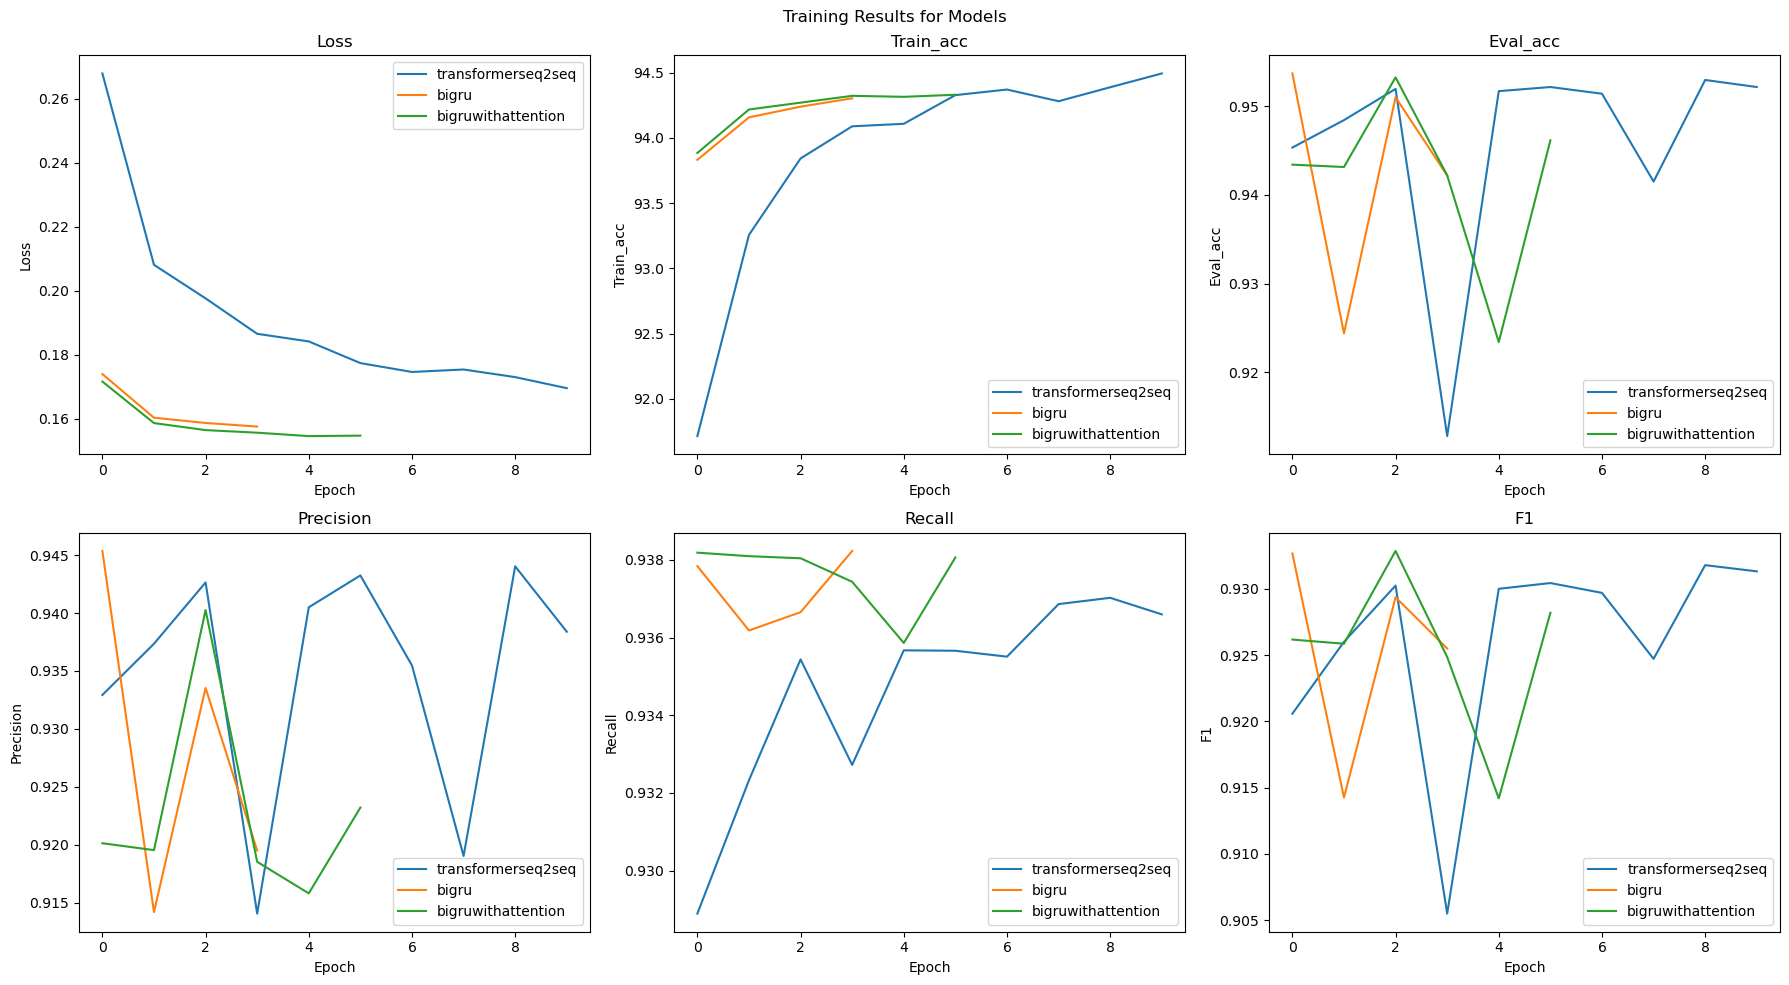

Best model is: BiGRUWithAttention with highest F1-score.


In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Function to save the model and tokenizer
def save_model_and_tokenizer(model, tokenizer, model_name, save_dir='saved_models'):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save the model state dict
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), model_path)
    
    # Save the tokenizer
    tokenizer_path = os.path.join(save_dir, f"{model_name}_tokenizer.pkl")
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    
    print(f"Model and tokenizer saved to {model_path} and {tokenizer_path}")


def train_and_evaluate_model(model, train_loader, test_loader, 
                             criterion, optimizer, num_epochs, 
                             patience=3, device='cuda', progress_bar=None):
    """
    Train and evaluate a given model.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the testing set.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        num_epochs (int): Number of epochs to train.
        patience (int): Number of epochs to wait before early stopping.
        device (str): Device to use for training (e.g., 'cuda' or 'cpu').
        progress_bar (tqdm.tqdm): Progress bar for training visualization.

    Returns:
        tuple: Training losses, training accuracy, evaluation accuracy, evaluation precision, evaluation recall, evaluation F1 score.
    """
    
    # Move model to the specified device
    model.to(device)
    
    # Lists to store metrics for each epoch
    training_losses = []
    training_accuracy = []
    evaluation_accuracy = []
    evaluation_precision = []
    evaluation_recall = []
    evaluation_f1 = []
    
    best_f1 = 0  # Best F1 score for early stopping
    epochs_without_improvement = 0  # Count of epochs without improvement
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total = 0
        correct = 0
        epoch_loss = 0
        
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            if isinstance(model, TransformerSeq2Seq):
                # For Transformer, generate mask (if necessary)
                src_mask = torch.triu(torch.ones(src.size(1), src.size(1)) * float('-inf'), diagonal=1).to(device)
                outputs = model(src)
            elif isinstance(model, Seq2Seq):
                # For Seq2Seq model
                num_classes = len(torch.unique(trg))
                output_size = model.decoder.output_size if hasattr(model.decoder, 'output_size') else num_classes
                trg_onehot = torch.nn.functional.one_hot(trg, num_classes=output_size).float().to(device)
                outputs = model(src, trg_onehot)
            else:
                # For BiGRU and BiGRUWithAttention models
                outputs = model(src)
            
            # Reshape outputs and target based on model type
            if outputs.dim() == 3:  # (batch_size, seq_len, num_classes)
                batch_size, seq_len, num_classes = outputs.size()
                
                if trg.dim() == 1 or (trg.dim() == 2 and trg.size(1) == 1):
                    # Sequence classification task
                    trg = trg.view(-1)
                    outputs = outputs[:, 0, :]  # Take the output of the first timestep
                else:
                    # Sequence generation task
                    if trg.size(1) != seq_len:
                        raise ValueError(f"Mismatch in sequence length: output seq_len = {seq_len}, target seq_len = {trg.size(1)}")
                    outputs = outputs.view(batch_size * seq_len, num_classes)  # Flatten to (batch_size * seq_len, num_classes)
                    trg = trg.view(batch_size * seq_len)  # Flatten target to (batch_size * seq_len)
            
            elif outputs.dim() == 2:  # (batch_size, num_classes)
                batch_size, num_classes = outputs.size()
                trg = trg.view(batch_size)  # Ensure target is flattened to (batch_size)
            
            # Compute loss
            loss = criterion(outputs, trg)
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            epoch_loss += loss.item() * trg.size(0)
            _, predicted = torch.max(outputs, 1)
            total += trg.size(0)
            correct += (predicted == trg).sum().item()
        
        # Average loss and accuracy for the epoch
        epoch_loss /= total
        epoch_accuracy = 100 * correct / total
        training_losses.append(epoch_loss)
        training_accuracy.append(epoch_accuracy)
        
        # Evaluation phase
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for src, trg in test_loader:
                src, trg = src.to(device), trg.to(device)
                if isinstance(model, TransformerSeq2Seq):
                    src_mask = torch.triu(torch.ones(src.size(1), src.size(1)) * float('-inf'), diagonal=1).to(device)
                    outputs = model(src)
                elif isinstance(model, Seq2Seq):
                    output_size = model.decoder.output_size if hasattr(model.decoder, 'output_size') else num_classes
                    trg_onehot = torch.nn.functional.one_hot(trg, num_classes=output_size).float().to(device)
                    outputs = model(src, trg_onehot)
                else:
                    outputs = model(src)

                if outputs.dim() == 3:  # (batch_size, seq_len, num_classes)
                    batch_size, seq_len, num_classes = outputs.size()
                    
                    if trg.dim() == 1 or (trg.dim() == 2 and trg.size(1) == 1):
                        trg = trg.view(-1)
                        outputs = outputs[:, 0, :]
                    else:
                        if trg.size(1) != seq_len:
                            raise ValueError(f"Mismatch in sequence length during evaluation: output seq_len = {seq_len}, target seq_len = {trg.size(1)}")
                        outputs = outputs.view(batch_size * seq_len, num_classes)
                        trg = trg.view(batch_size * seq_len)
                
                _, predicted = torch.max(outputs, dim=-1)
                
                all_preds.extend(predicted.cpu().numpy().flatten())
                all_labels.extend(trg.cpu().numpy().flatten())
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        evaluation_accuracy.append(accuracy)
        evaluation_precision.append(precision)
        evaluation_recall.append(recall)
        evaluation_f1.append(f1)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%, '
              f'Evaluation Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
        
        # Early stopping check
        if f1 > best_f1:
            best_f1 = f1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break
            
        # Update the progress bar
        if progress_bar is not None:
            progress_bar.update(1)
            progress_bar.set_postfix(loss=epoch_loss, train_acc=epoch_accuracy, eval_acc=accuracy)
    
    return training_losses, training_accuracy, evaluation_accuracy, evaluation_precision, evaluation_recall, evaluation_f1

# Main training loop with model saving
def train_and_select_best_model(models, train_loader, test_loader, 
                                num_epochs, patience=3, device='cuda'):
    """
    Train multiple models and return the one with the highest F1-score.

    Args:
        models (list): List of models to train.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the testing set.
        num_epochs (int): Number of epochs to train.
        patience (int): Number of epochs to wait before early stopping.
        device (str): Device to use for training (e.g., 'cuda' or 'cpu').

    Returns:
        best_model (torch.nn.Module): Model with the highest F1-score.
    """
    
    best_f1 = 0
    best_model = None
    best_model_state = None
    results = {}

    for model in models:
        model_name = type(model).__name__.lower()
        train_dataset = TensorDataset(X_train, y_train)
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_dataset.tensors[1].cpu().numpy()),
            y=train_dataset.tensors[1].cpu().numpy())
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        print(f"\nTraining model: {type(model).__name__}")
        
        # Train and evaluate the model
        with tqdm(total=num_epochs, desc=f"Training {model_name}", unit="epoch") as pbar:
            losses, train_acc, eval_acc, precision, recall, f1 = train_and_evaluate_model(
                model, train_loader, test_loader, criterion, optimizer, 
                num_epochs, patience, device, progress_bar=pbar
            )
        
        # Collect the results for plotting
        results[model_name] = {
            'loss': losses,
            'train_acc': train_acc,
            'eval_acc': eval_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        # Save the model and tokenizer
        tokenizer = {'word_to_idx': {}, 'idx_to_word': {}}  # Replace with your actual tokenizer
        save_model_and_tokenizer(model, tokenizer, model_name)
        
        # Check if this model has the best F1 score
        if max(f1) > best_f1:
            best_f1 = max(f1)
            best_model = model
            best_model_state = model.state_dict()
    
    # Load the best model state
    if best_model_state:
        best_model.load_state_dict(best_model_state)

    # Plot the results
    plot_results(results)
    
    return best_model, results

def plot_results(results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training Results for Models')
    
    metrics = ['loss', 'train_acc', 'eval_acc', 'precision', 'recall', 'f1']
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        for model_name, model_results in results.items():
            axes[i].plot(model_results[metric], label=model_name)
        axes[i].set_title(metric.capitalize())
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

# Assuming train_loader, test_loader, num_epochs, and patience are defined
models = [transformer_seq, bigru, bigruwithattention]
best_model = train_and_select_best_model(models, train_dataloader, test_dataloader, num_epochs, patience, device)

print(f"Best model is: {type(best_model).__name__} with highest F1-score.")


NameError: name 'results' is not defined

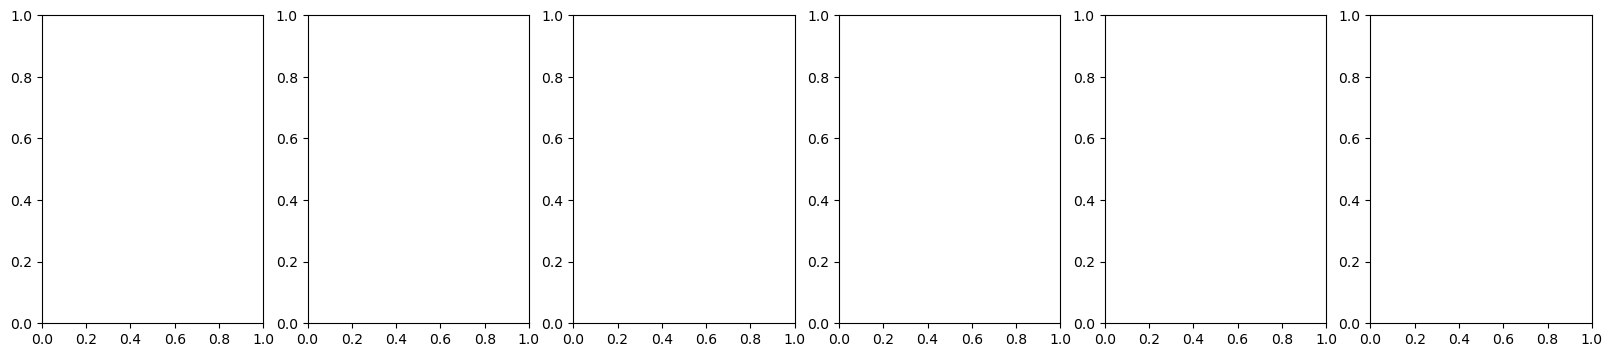

In [8]:
# Define the metrics we want to plot
metrics = ['loss', 'train_acc', 'eval_acc', 'precision', 'recall', 'f1']

# Set up the figure and axes for the panel plot
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

# Loop through each metric
for j, metric in enumerate(metrics):
    ax = axes[j]
    
    # Plot each model's results for the current metric
    for model_name, metrics_dict in results.items():
        ax.plot(metrics_dict[metric], label=model_name)
        
    # Set plot titles and labels
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)
    
    # Add a legend to the last subplot
    if j == len(metrics) - 1:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()
